In [ ]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
from folder import StandardFolder
from polars_utils import *

# OUTPUTS
FOLDER_OUT = Path("D:/Prut/Warehouses/output/Jun24/n/af")

# INPUTS
# Cases in our other cohorts
# FOLDER_OC = StandardFolder("H:/Shared drives/Datalake/Data/20240630_fu")
FOLDER_OC = StandardFolder(r"D:\Datalake\Data\20240630_fu_nc")
# Cases not in any cohorts, i.e. new cases
# FOLDER_NC = StandardFolder("H:/Shared drives/Datalake/Loosely_criteria_data/newcase_202406(Jan-June2024)/Data for new case iden 202406")
FOLDER_NC = StandardFolder(r"D:\Datalake\Data\Data for new case iden 202406")

er_emr not included.
summary_discharge not included.
dimension table not included.


In [25]:
# PREV_AF = 'D:/Prut/Warehouses/output/Dec23/n/AF/af_n_21032024.csv'
# prev_af = pd.read_csv(PREV_AF)['ENC_HN'] # 23301
# assert len(prev_af) == prev_af.nunique()
prev_af: list = pl.scan_parquet('D:/Prut/Warehouses/output/Dec23/wh/complete/AF_warehouse_exported_22-02-2024.parquet.gzip').select(pl.col('ENC_HN')).collect().unique().to_series().to_list() # 23337
print(len(prev_af))

23337


In [14]:
# AF standard values
AF_STANDARD = "D:/Prut/Warehouses/std/meds_AF.csv"
af_std_df = pd.read_csv(AF_STANDARD)
af_icd_re = '^I48'
af_drugcodes: list = af_std_df["CODE"].tolist()
af_drugcodes_re: str = "|".join(af_drugcodes)
print(af_drugcodes_re)

COUM2T-|PRAD2C-|ELIQ1T-|LIXI-T-|XARE1T-|XARE2T-|XARE3T-|PRAD1C-|PRAD-C-|ORFR1T-|ORFR2T-|XARE-T-


In [15]:
def get_dx(paths: list[Path], re: str, streaming: bool=False):
    to_concat = []
    # Loop through all files
    for path in paths:
        # Scan and parse dates
        file = (
            scan_file(path)
            .select(pl.col(['ENC_HN', 'D001KEY', 'D035KEY']))
        )
        file = parse_dates(file, 'D001KEY', format="%Y%m%d")
        # Select desired ICD10 codes
        file = file.filter(pl.col('D035KEY').str.contains(re))
        # One day per row
        file = file.group_by(pl.col(['ENC_HN', 'D001KEY'])).agg(pl.col('D035KEY')).with_columns(pl.col('D035KEY').list.unique().list.sort().list.join(', '))
        file = file.collect(streaming=streaming)
        to_concat.append(file)
    return pl.concat(to_concat).unique()


def get_drug(paths: list[Path], re: str, streaming: bool=False):

    to_concat = []
    for path in paths:
        file = scan_file(path)
        # Deal with alternative file structures
        if {'PER_DATE_2', 'SERVICE_ID', 'CAL_SER_AMT'}.issubset(file.columns):
            file = file.rename({'PER_DATE_2': 'D001KEY', 'SERVICE_ID': 'D033KEY', 'CAL_SER_AMT': 'M1022'})
        file = file.select(pl.col(['ENC_HN', 'D001KEY', 'D033KEY', 'M1022']))

        file = parse_dates(file, 'D001KEY', format="%Y%m%d")

        file = file.filter(pl.col('D033KEY').str.contains(re))

        to_concat.append(file.collect(streaming=streaming))

    return pl.concat(to_concat)

In [16]:
med_paths = list(FOLDER_OC.bill.iterdir()) + list(FOLDER_NC.meds.iterdir()) # Some bills some meds, must manually check
med_paths = med_paths[::-1] # remove [:n]

med = get_drug(med_paths, af_drugcodes_re, streaming=True)
med

ENC_HN,D001KEY,D033KEY,M1022
str,date,str,str
"""C90B3BCAF1EB45…",2024-03-18,"""LIXI-T-""","""5.071942446043…"
"""C90B3BCAF1EB45…",2024-03-18,"""LIXI-T-""","""24.92805755395…"
"""EE007C9DFBDE08…",2024-03-25,"""ORFR1T-""","""113"""
"""1DDEE5D2492E14…",2024-03-11,"""ORFR1T-""","""266.6666666666…"
"""B3C7264D401194…",2024-03-21,"""LIXI-T-""","""124.6402877697…"
"""B3C7264D401194…",2024-03-21,"""LIXI-T-""","""25.35971223021…"
"""BD1A2799C063A7…",2024-03-08,"""LIXI-T-""","""6.762589928057…"
"""1B7FE37D1F7ACE…",2024-03-06,"""ORFR1T-""","""33"""
"""647B66F0E187A6…",2024-03-06,"""ORFR1T-""","""11.66666666666…"


In [17]:
med['ENC_HN'].n_unique()

21075

<Axes: title={'center': 'Dementia drug codes Jan 2010 to Jun 2024'}, xlabel='Drug code', ylabel='Count'>

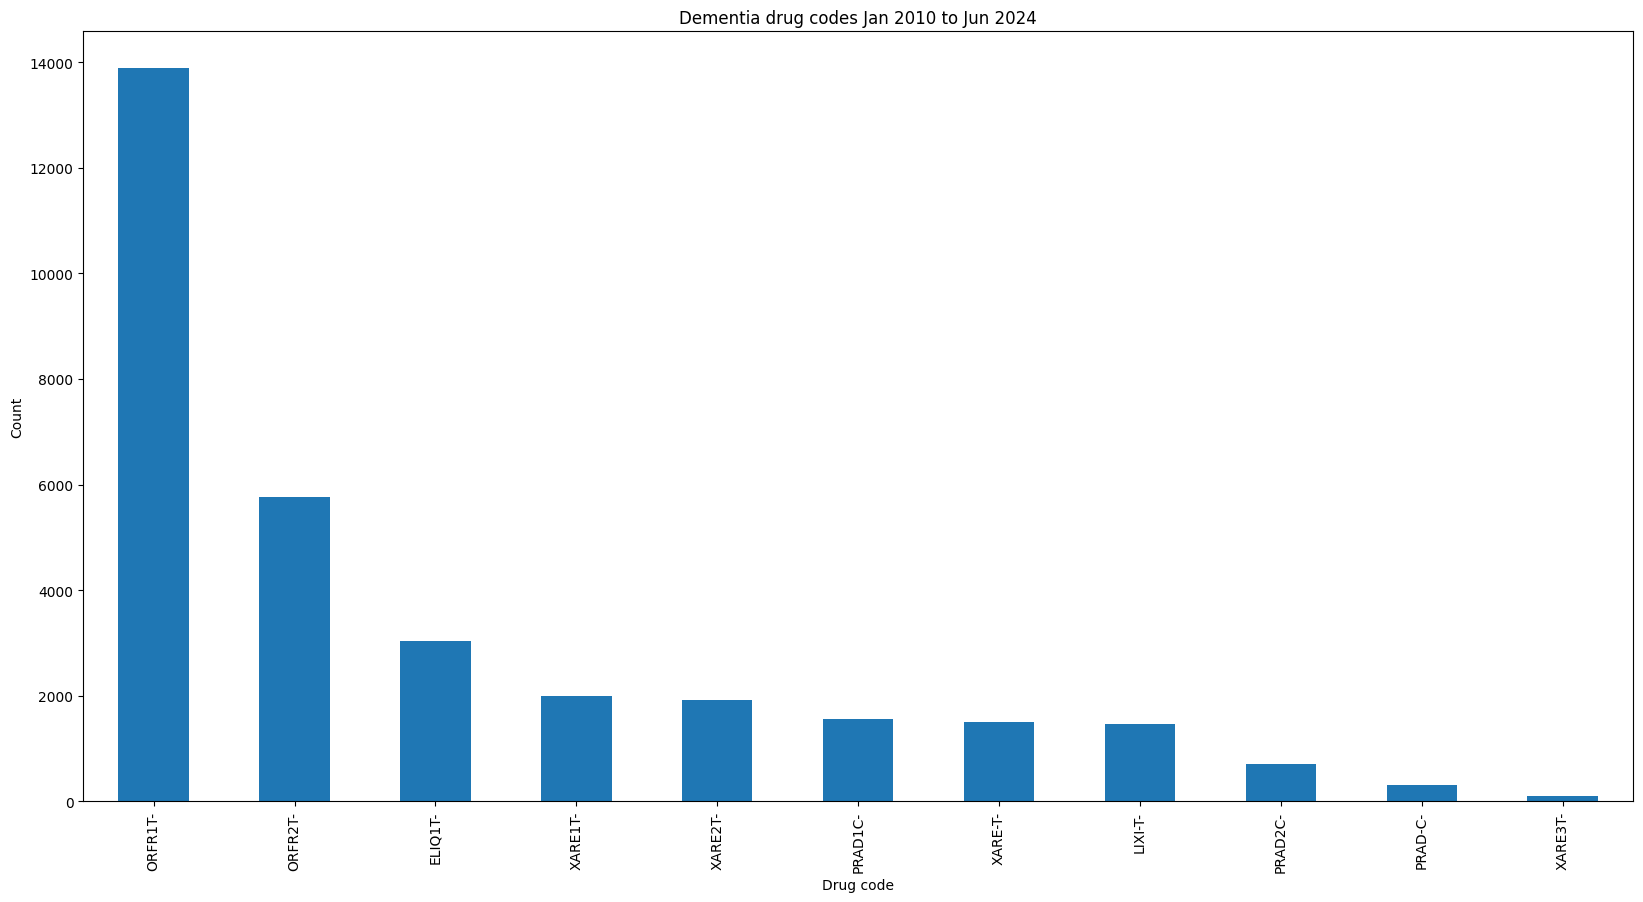

In [18]:
med.select('ENC_HN', 'D033KEY').unique().to_pandas()['D033KEY'].value_counts().plot(kind='bar', figsize=(20, 10), title='Dementia drug codes Jan 2010 to Jun 2024', xlabel='Drug code', ylabel='Count')

D033KEY
Warfarin sodium         19653
Rivaroxaban              5526
Apixaban                 3048
Dabigatran etexilate     2589
Edoxaban tosilate        1466
Name: count, dtype: int64

<Axes: title={'center': 'AF drugs from Jan 2010 to Jun 2024'}, xlabel='Drug name', ylabel='Count'>

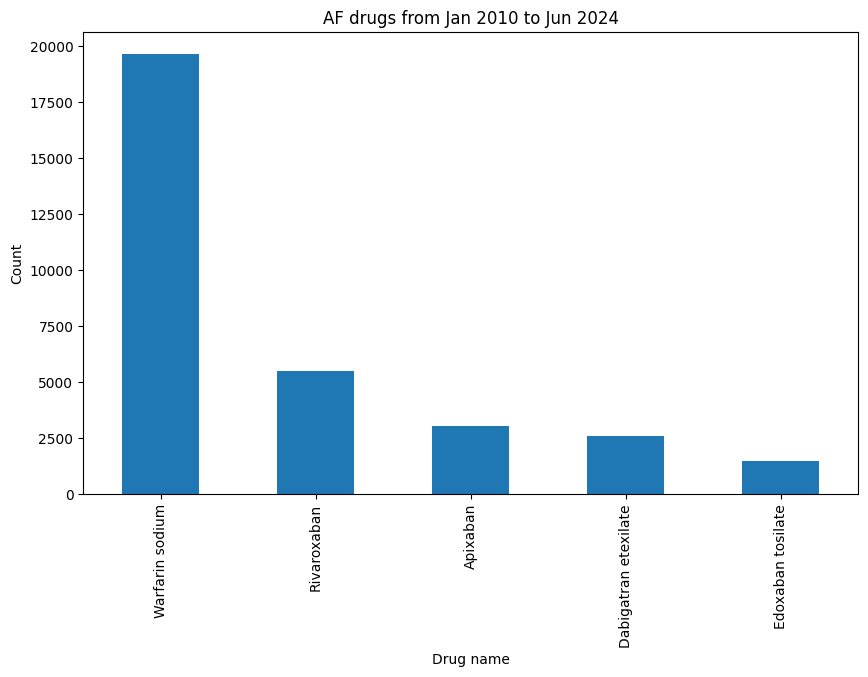

In [25]:
std_dict = dict(zip(af_std_df['CODE'], af_std_df['ชื่อสามัญ']))
std_cnt = med.select('ENC_HN', 'D033KEY').unique().to_pandas()['D033KEY'].map(std_dict).value_counts()
display(std_cnt)
std_cnt.plot(kind='bar', figsize=(10, 6), title='AF drugs from Jan 2010 to Jun 2024', xlabel='Drug name', ylabel='Count')

In [26]:
dx_paths = list(FOLDER_OC.dx.iterdir()) + list(FOLDER_NC.dx.iterdir())

dx = get_dx(dx_paths, re=af_icd_re, streaming=False)
dx

ENC_HN,D001KEY,D035KEY
str,date,str
"""B04EFEFFA141DA…",2014-05-17,"""I48"""
"""12EAC014F34643…",2014-07-02,"""I48"""
"""E98FFF0D13B841…",2014-11-14,"""I48"""
"""983CF0418F74C7…",2014-05-27,"""I48"""
"""83972FA0DD1ECB…",2014-12-09,"""I48"""
"""872421710E37C1…",2014-12-04,"""I48"""
"""C99F7F9E5AF5B0…",2014-04-11,"""I48"""
"""8F9BC59AF38BB3…",2014-08-13,"""I48"""
"""5613C6BD7FE225…",2014-06-12,"""I48"""


In [27]:
dx['ENC_HN'].n_unique()

20825

In [30]:
def add_bool(df):
    return df.with_columns(
        pl.col('D035KEY').is_not_null().alias('ICD_exists'),
        pl.col('D033KEY').is_not_null().alias('Med_exists'),
        (pl.col('D035KEY').is_not_null() & pl.col('D033KEY').is_not_null()).alias('Both_exists'),
    )

In [35]:
combined = dx.join(med, on=['ENC_HN', 'D001KEY'], how='outer_coalesce',)
combined = add_bool(combined)
combined.write_csv(FOLDER_OUT / 'af_full_n=29636_Jun2024.csv')

In [32]:
combined

ENC_HN,D001KEY,D035KEY,D033KEY,M1022,ICD_exists,Med_exists,Both_exists
str,date,str,str,str,bool,bool,bool
"""C90B3BCAF1EB45…",2024-03-18,"""I480""","""LIXI-T-""","""5.071942446043…",true,true,true
"""C90B3BCAF1EB45…",2024-03-18,"""I480""","""LIXI-T-""","""24.92805755395…",true,true,true
"""EE007C9DFBDE08…",2024-03-25,"""I480""","""ORFR1T-""","""113""",true,true,true
"""1DDEE5D2492E14…",2024-03-11,null,"""ORFR1T-""","""266.6666666666…",false,true,false
"""B3C7264D401194…",2024-03-21,null,"""LIXI-T-""","""124.6402877697…",false,true,false
"""B3C7264D401194…",2024-03-21,null,"""LIXI-T-""","""25.35971223021…",false,true,false
"""BD1A2799C063A7…",2024-03-08,"""I480""","""LIXI-T-""","""6.762589928057…",true,true,true
"""1B7FE37D1F7ACE…",2024-03-06,null,"""ORFR1T-""","""33""",false,true,false
"""647B66F0E187A6…",2024-03-06,null,"""ORFR1T-""","""11.66666666666…",false,true,false


In [33]:
combined['ENC_HN'].n_unique()

29636

In [34]:
combined.group_by('ENC_HN').agg(
    pl.max('ICD_exists').alias('ICD_exists'),
    pl.max('Med_exists').alias('Med_exists'),
    pl.max('Both_exists').alias('Both_exists'),
).sum()

ENC_HN,ICD_exists,Med_exists,Both_exists
str,u32,u32,u32
null,20825,21075,10412


In [59]:
combined_filtered = clip_dates(combined, 'D001KEY', start_year=2024, start_month=1, start_day=1, end_year=2024, end_month=6, end_day=30)
combined_filtered = combined_filtered.filter(~pl.col('ENC_HN').is_in(prev_af))

In [60]:
combined_filtered['ENC_HN'].n_unique()

2661

In [61]:
combined_filtered.group_by('ENC_HN').agg(
    pl.max('ICD_exists').alias('ICD_exists'),
    pl.max('Med_exists').alias('Med_exists'),
    pl.max('Both_exists').alias('Both_exists'),
).sum()

ENC_HN,ICD_exists,Med_exists,Both_exists
str,u32,u32,u32
null,702,2259,222


# Combination with ECG / Holter

In [7]:
combined = pl.read_csv(FOLDER_OUT / 'af_full_n=29636_Jun2024.csv')

In [45]:
df_icd_new = (
    combined.groupby('ENC_HN').agg(
    pl.col('D001KEY').min()
    )
    .with_columns(pl.col('D001KEY').cast(pl.Date).alias('First_date'))
    .filter(pl.col('First_date').dt.year() == 2024)
    .select('ENC_HN', 'First_date')
)

df_icd_new

C:\Users\PC5\AppData\Local\Temp\ipykernel_724388\2270157968.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  combined.groupby('ENC_HN').agg(


ENC_HN,First_date
str,date
"""F038E4938A509C…",2024-06-22
"""57AE377749607D…",2024-01-20
"""1CE0E62D0E54F8…",2024-06-28
"""A3D9DA5C8E71C9…",2024-01-15
"""36AC1BC804A34E…",2024-02-07
"""4B8A6639983169…",2024-05-07
"""A16FAED2014B99…",2024-06-24
"""D3FDE910AE441E…",2024-05-18
"""EB71674600D760…",2024-02-27


In [41]:
df_ecgholter = (
    pl.read_excel(r"D:\Prut\Warehouses\output\Jun24\n\af\df_af_use_send.xlsx")
    .with_columns(pl.col('Date').cast(pl.Date))
    .filter(pl.col('Date').dt.year() == 2024)
    .filter(pl.col('Date').dt.month() <= 6)
)
assert len(df_ecgholter) == df_ecgholter.select('ENC_HN').n_unique()
df_ecgholter

ENC_HN,how,Date
str,str,date
"""EFF5117A1CB5DF…","""holter""",2024-03-12
"""1873948AF42279…","""holter""",2024-06-13
"""4C6FF132C85C18…","""holter""",2024-06-24
"""665825A27A6B5D…","""holter""",2024-04-26
"""D3D7481EB797CE…","""holter""",2024-05-31
"""81EB5B867657D2…","""holter""",2024-04-05
"""7ADECB0A456BD2…","""holter""",2024-02-07
"""C37111FE266884…","""holter""",2024-02-21
"""9A7A7BC215BE2B…","""holter""",2024-03-27


In [27]:
prev = pl.scan_parquet('D:/Prut/Warehouses/output/Dec23/wh/complete/AF_warehouse_exported_22-02-2024.parquet.gzip').select(pl.col('ENC_HN', 'Date')).unique().collect()

In [32]:
prev

ENC_HN,Date
str,date
"""4BBD19D63DBACE…",2010-03-25
"""79F79E888ABB95…",2010-06-04
"""65446E0B9B58B6…",2012-03-30
"""6B961BA28941E7…",2012-10-03
"""71557A6FF96E05…",2013-09-13
"""73353B7EDCB7B5…",2013-11-27
"""A2C87CCCB3C595…",2014-02-28
"""E94F1F64C46BAF…",2014-02-21
"""D6D1E2B7F6D595…",2016-11-29


In [38]:
df_prev = (
    prev.groupby('ENC_HN').agg(
    pl.col('Date').min()
    )
    .rename({'Date': 'First_date'})
    .filter(pl.col('First_date').dt.year() < 2024)
)
df_prev

C:\Users\PC5\AppData\Local\Temp\ipykernel_724388\305814982.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  prev.groupby('ENC_HN').agg(


ENC_HN,First_date
str,date
"""288B86530838A5…",2010-03-05
"""1AB1321AD65F4D…",2016-02-16
"""64A72143388F62…",2010-06-21
"""A76E252A6DFA9F…",2016-01-27
"""4E0FA7A59F6F99…",2013-07-15
"""B552A9834DB165…",2018-05-24
"""2238DDA8CE4EAB…",2010-04-01
"""82ED9BB8930B59…",2010-05-06
"""988D253427CFBB…",2011-12-08


In [39]:
df_prev

ENC_HN,First_date
str,date
"""288B86530838A5…",2010-03-05
"""1AB1321AD65F4D…",2016-02-16
"""64A72143388F62…",2010-06-21
"""A76E252A6DFA9F…",2016-01-27
"""4E0FA7A59F6F99…",2013-07-15
"""B552A9834DB165…",2018-05-24
"""2238DDA8CE4EAB…",2010-04-01
"""82ED9BB8930B59…",2010-05-06
"""988D253427CFBB…",2011-12-08


In [47]:
df_icd_new['ENC_HN'].unique() 

ENC_HN
str
"""2AF566A73B74A3…"
"""E2796C133115F4…"
"""87D53AC35688E6…"
"""3685EDB79216A5…"
"""1B7E9229896F9F…"
"""EE111BF1FF26DC…"
"""57AE377749607D…"
"""C8DD72E206432E…"
"""09BBA3142E4E3C…"


In [44]:
df_prev

ENC_HN,First_date
str,date
"""288B86530838A5…",2010-03-05
"""1AB1321AD65F4D…",2016-02-16
"""64A72143388F62…",2010-06-21
"""A76E252A6DFA9F…",2016-01-27
"""4E0FA7A59F6F99…",2013-07-15
"""B552A9834DB165…",2018-05-24
"""2238DDA8CE4EAB…",2010-04-01
"""82ED9BB8930B59…",2010-05-06
"""988D253427CFBB…",2011-12-08


In [43]:
df_ecgholter.select('ENC_HN').to_series().to_list()

['EFF5117A1CB5DF294C3F2931AF098A861EFE6C7D63E594FEA20C499BD3E60335',
 '1873948AF42279D988D97E03EACE4FED3771AC12B2DC67DA9C06BD8122FC0CBB',
 '4C6FF132C85C18F04F2C3C12B5F05CBF28602D9B7FCB9753D120991D40CC2B6A',
 '665825A27A6B5D3F6EED72FC377954C4788CEE68AC17D22270AF285F93397C56',
 'D3D7481EB797CE46EE84D8060C5B2BE20EFEBB31712F0EF709ED84D568FC0B93',
 '81EB5B867657D21FEDAD472C3C356A87C74DA94156460F6CC9F1E7BF402B49D9',
 '7ADECB0A456BD299CD924668C99E6EE10F510D7C90E78B8FAEC12ECE0C601CE2',
 'C37111FE266884067CED0C3598E3AAAD757A3F3997D571A9A8DDD5B0B83CCABE',
 '9A7A7BC215BE2B4E1F8DD8AED6D6C45A76B99D878D593CA9E298CDA00D753AFD',
 'C440155E32FC6C60EB420765890116414398ECA53D204D8BA3A973B74C2BD2E5',
 '1024616289BC82F69E851FB902BEB148CE3DA5DB1650BC6E3F2B6F90192156D1',
 'BB71A9C1AD827416D49B6287EBA6E70267D30DE54246EB080E9F48B9ADDC8594',
 '9F8AAD15A5FDF9ADDAAF405F6FFF75036820ED0595E8C242AAA54AE15B42B65A',
 'E6EBA6073EB659D4A811E841AE2E44FD9FE429C8FE8FAA0BBAE83B059B759168',
 '50853172585C4E8CB1D575FE33019B97

In [51]:
eh = df_ecgholter.filter(~pl.col("ENC_HN").is_in(df_prev.select('ENC_HN').to_series().to_list()))
eh

ENC_HN,how,Date
str,str,date
"""EFF5117A1CB5DF…","""holter""",2024-03-12
"""4C6FF132C85C18…","""holter""",2024-06-24
"""D3D7481EB797CE…","""holter""",2024-05-31
"""81EB5B867657D2…","""holter""",2024-04-05
"""9A7A7BC215BE2B…","""holter""",2024-03-27
"""1024616289BC82…","""holter""",2024-03-05
"""50853172585C4E…","""holter""",2024-03-22
"""84BC9C12A85E43…","""holter""",2024-05-30
"""69779A753BEB09…","""holter""",2024-05-01


In [53]:
eh.filter(pl.col("ENC_HN").is_in(df_icd_new.select('ENC_HN').to_series().to_list()))

ENC_HN,how,Date
str,str,date
"""EFF5117A1CB5DF…","""holter""",2024-03-12
"""69779A753BEB09…","""holter""",2024-05-01
"""E28C2923A226E9…","""holter""",2024-02-13
"""0F2DE605C9BFF3…","""holter""",2024-01-24
"""9BA3CAD5BECA29…","""holter""",2024-05-31
"""5BDCED29D3AC12…","""holter""",2024-02-22
"""A89007ABD6DAD0…","""holter""",2024-01-29
"""C539042D4191A1…","""holter""",2024-02-07
"""7D4D720F3B85E1…","""holter""",2024-04-22


In [54]:
df_prev

ENC_HN,First_date
str,date
"""288B86530838A5…",2010-03-05
"""1AB1321AD65F4D…",2016-02-16
"""64A72143388F62…",2010-06-21
"""A76E252A6DFA9F…",2016-01-27
"""4E0FA7A59F6F99…",2013-07-15
"""B552A9834DB165…",2018-05-24
"""2238DDA8CE4EAB…",2010-04-01
"""82ED9BB8930B59…",2010-05-06
"""988D253427CFBB…",2011-12-08


In [55]:
df_icd_new

ENC_HN,First_date
str,date
"""F038E4938A509C…",2024-06-22
"""57AE377749607D…",2024-01-20
"""1CE0E62D0E54F8…",2024-06-28
"""A3D9DA5C8E71C9…",2024-01-15
"""36AC1BC804A34E…",2024-02-07
"""4B8A6639983169…",2024-05-07
"""A16FAED2014B99…",2024-06-24
"""D3FDE910AE441E…",2024-05-18
"""EB71674600D760…",2024-02-27


In [57]:
df_eh = eh.select('ENC_HN', 'Date').rename({'Date': 'First_date'})
df_eh

ENC_HN,First_date
str,date
"""EFF5117A1CB5DF…",2024-03-12
"""4C6FF132C85C18…",2024-06-24
"""D3D7481EB797CE…",2024-05-31
"""81EB5B867657D2…",2024-04-05
"""9A7A7BC215BE2B…",2024-03-27
"""1024616289BC82…",2024-03-05
"""50853172585C4E…",2024-03-22
"""84BC9C12A85E43…",2024-05-30
"""69779A753BEB09…",2024-05-01


In [60]:
df_cohort1 = pl.concat([df_prev, df_icd_new, df_eh]).group_by('ENC_HN').agg(pl.col('First_date').min())
df_cohort1

ENC_HN,First_date
str,date
"""414BAE44B2F11B…",2010-01-08
"""7137092ECD6598…",2021-11-20
"""ED3E174E3B5159…",2010-02-11
"""CC05216CF3F04E…",2010-01-20
"""24D64EC5F89030…",2012-07-09
"""FF3227707B0C4A…",2019-12-20
"""02A0F3975031AB…",2010-12-13
"""8831ADC19F618A…",2010-01-13
"""13041E6D65BEDE…",2010-06-01


In [61]:
df_cohort2 = df_cohort1.filter(pl.col('First_date').dt.year() >= 2010)
df_cohort2

ENC_HN,First_date
str,date
"""414BAE44B2F11B…",2010-01-08
"""7137092ECD6598…",2021-11-20
"""ED3E174E3B5159…",2010-02-11
"""CC05216CF3F04E…",2010-01-20
"""24D64EC5F89030…",2012-07-09
"""FF3227707B0C4A…",2019-12-20
"""02A0F3975031AB…",2010-12-13
"""8831ADC19F618A…",2010-01-13
"""13041E6D65BEDE…",2010-06-01


In [62]:
df_cohort2.write_csv(FOLDER_OUT / 'af_cohort_n=24928_Jun2024.csv')